# __Project WebCensus: Analyzing Web Data to Understand How Web Frameworks Impact Websites__
## __Spring 2024 Data Science Project__

Om Duggineni, Vishnu Kumar, Jason Wu

# Project Contributions:

1. **Project idea** (5%) - Om Duggineni (5%)
  - This project was Om's idea, initially.
2. **Dataset Curation and Preprocessing** (10%) - Om Duggineni (10%), Vishnu Kumar (5%), Jason (5%)
  - Om did all the initial steps of dataset curation, including sourcing data from the WhatRuns website, building the initial steps such as the web scraping script, JavaScript tricks for loading data from the WhatRuns website, and the IP address instrumentation script
  - Vishnu and Jason helped with the process of data loading and changing data types in the final dataset, as well as with a few minor filtering steps to make the dataset fit in memory (including filtering less-popular sites from the dataset by limiting the "popularity rank" of websites used), allowing us to proceed with further exploratory data analysis steps.
3. **Data Exploration and Summary Statistics** (10%) - all
  - Part 2 (on Exploratory Data Analysis) was split evenly, with Vishnu doing conclusion #1, Jason doing conclusion #2, and Om doing conclusion #3
4. **ML Algorithm Design/Development** (25%) - all
  - Om wrote the preprocessing code for converting the dataset into a format that the ML model understood (this involved parsing the JSON web framework data into the one-hot encoded form that the model uses). This helped inform the design and developement of the ML model.
  - Jason and Vishnu worked on the code for training the ML model using a Random Forest-based algorithm
5. **ML Algorithm Training and Test Data Analysis** (20%) - all
  - Om worked on the code for loading data into the model and suggested Random Forests as a possible model to use
  - Vishnu and Jason worked on the code for training the model and displaying the results of training said model
6. **Visualization, Result Analysis, Conclusion** (15%) - all
7. **Final Tutorial Report Creation** (10%) - all
  - Om wrote part 1 of the final project tutorial report (on collecting the data), including images and the Hilbert-space IP address map.
  - Vishnu wrote part 2 of the final project tutorial report, 
  - Part 3 was split among us three evently, with Vishnu doing conclusion #1, Jason doing conclusion #2, and Om doing conclusion #3
  - The preprocessing part of part 4 was done my Om, and the actual training code was split between Vishnu and Jason
  - Part 5 was evenly split between Vishnu and Jason.
8. **Additional (not listed above, if any)** (5%) - all

Note: parts 3, 4, 5, 6, and 7 were done together in a zoom call

Member 1: Om Duggineni - 100%

Member 2: Vishnu Kumar - 90%

Member 3: Jason -Wu  90%


We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.

- Om Duggineni, Vishnu Kumar, Jason Wu 

Date: 5/7/2024

# Explanation of roles

**Om Duggineni:**
- Wrote the initial scripts to collect the dataset
- Wrote Part 1 of the final project tutorial report, on collecting the dataset
- Wrote the dataset preprocessing notebooks
- Wrote the scripts analyzing the WhatRuns objects and parsing them for use in the random forest model, assisted in fixing bugs
- Did conclusion 3 in exploratory data analysis

**Jason:**
- Assisted in the preprocessing stage by condensing redundant columns as well as handling missing values
- Did Analysis and conclusion 2 in the exploratory analysis
- Worked on splitting the data set, training the data, and getting evaluation 
alues such as the mean squared error and $r^2$ coefficient

**Vishnu:**
- Wrote Part 2 of the final project tutorial report 
- Did analysis and conclusion 1 in explorartory analysis 
- Worked on main model as well as the visualization of RandomForestRegressor
- Assisted with minor formatting/styling 

# Library Imports

In [1]:
%pip install --quiet numpy-hilbert-curve
import matplotlib.pyplot as plt # matplotlib, for plotting
import matplotlib.patches as mpatches
import numpy as np # numpy, for numerical processing
import pandas as pd # pandas, for data processing
import hilbert # the IP address visualization
import json # json, for parsing WhatRuns objects
from tqdm.auto import tqdm, trange # tqdm, for creating progress bars
import random # for randomization of values
from sklearn.model_selection import train_test_split # for splitting data into a train and test dataset
from sklearn.ensemble import RandomForestRegressor # random forest model for regression
from sklearn.metrics import mean_squared_error, r2_score # metrics for evaluating the model
from joblib import parallel_backend # for making scikit-learn training faster
import re # for parsing and editing strings
from scipy.stats import kruskal, ttest_ind, f_oneway, contingency as cont, mannwhitneyu # for Kruskal-Wallis testing, t-testing, ANOVA testing, and contingency table testing
from statsmodels.stats.multitest import multipletests # used for pairwise testing
from functools import reduce # used to join a list of sets together into one big set
import sys # sys.intern() for saving memory when having a bunch of strings loaded


%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


# __Introduction__

The main goal of our project is to do a "census" of the most popular 10 billion websites on the internet. To this end, this project gathers metadata for these websites, including website preformance metrics, popularity, and internal insights into what web frameworks these websites run on.

The main question we're trying to answer is what frameworks are most widely used and for what type of website are they used for? This is an important question as understanding what frameworks work well for top websites can point us to why they are so popular and what attributes about them make them work so well for certain functions. Some other questions were trying to answer are what domains are more popular on certain devices and if using a cloud provider affects website preformance? These questions are also important as they find out what websites are more common on certain devices and possibly why this may be occurring as well as understanding the importance of cloud providers and when they are necessary.

## __Part 1: Obtaining The Data__

This project involves a large dataset, assembled from a combination of web scraping techniques, DNS lookup info, and the data present within the Chrome User Experience Report (CrUX) dataset. This involves the following steps:

- Gathering a list of websites from the CrUX dataset using Google's BigQuery tool, giving us information such as performance metrics and relative popularity
- Scraping a Chrome extension in order to determine what frameworks the website runs, giving us a list of frameworks the website runs
- Using DNS instrumentation in order to detect the most common public cloud providers, allowing us to determine whether a website uses a particular cloud provider for their public-facing servers.

The scripts we used for web scraping are publicly avaliable on GitHub at https://github.com/web-frameworks-research/web_framework_scraper. They were run using a series of Jupyter notebooks which are avaliable at https://github.com/web-frameworks-research/conversion_and_analysis_pipeline.

### __1.1: Downloading Data from the CrUX dataset using BigQuery__

The Chrome User Experience Report (CrUX) dataset is publicly avaliable to anybody with a Google account. To do so, follow these steps:

1. First, go to the Google Cloud console at https://console.cloud.google.com/, and create a new project.

![An image showing the Google Cloud console](google-cloud-1.png)

2. Follow this link to view the CrUX dataset: [CrUX dataset on BigQuery](https://console.cloud.google.com/bigquery?p=chrome-ux-report&d=all&page=dataset)

3. Use BigQuery tools to export the [`device_summary`](https://developer.chrome.com/docs/crux/bigquery#schema-device-summary) table to sharded, gzipped CSV files, which can later be loaded into the rest of the preprocessing and analysis pipeline.

This project uses the [`device_summary`](https://developer.chrome.com/docs/crux/bigquery#schema-device-summary) table for it's analysis. This table contains aggregated data around website performance by domain and device form factor, including website popularity and performance metrics. We can save significant amounts of compute time and storage space by using this table directly instead of downloading the entire dataset.

### __1.2: Using web scraping to find web framework data__

#### What are web frameworks?

Most websites use some set of *web frameworks*, in addition to their own HTML and JavaScript code, in order to reduce code repetition and make building complex user interfaces easier. These web frameworks come in a variety of for

#### What is WhatRuns?

WhatRuns.com is a very cool Chrome extension that can determine what web frameworks a website uses. It works by using a proprietary pattern recognition algorithm to identify frameworks, such as React, Angular, jQuery, and Bootstrap, that are responsible for running the website.

You can use the WhatRuns Chrome extension [here](https://chromewebstore.google.com/detail/whatruns/cmkdbmfndkfgebldhnkbfhlneefdaaip). The extension internally renders the page at `https://www.whatruns.com/website/<website's domain name>`, allowing one to look at the data for any particular website without downloading the Chrome extension.

#### Original Attempt - `puppeteer`

For the original attempt at scraping data from the WhatRuns website, we used the `puppeteer` framerwork to open the WhatRuns website in a headless (no graphics display) version of the Google Chrome browser. However, this attempt ran into a few issues:

- All assets (such as images) had to be loaded from the website each time we opened 
- High CPU and memory usage from opening tens or hundreds of headless browser tabs at once
- Performance issues - Due to the above issues, we can only measure the frameworks for two to five websites per second. This was too slow.

#### JavaScript tricks - Runtime Scope Inspection

Since loading the website in a headless browser is far too slow, we needed to find a method that worked faster for this website. It turns out that, to display the list of web frameworks in a website, whatruns.com uses JavaScript code that is hardcoded in a `<script>` tag and generated server-side. This means that the code displaying this list, at some point, sets a variable to a JavaScript object containing the list of frameworks. We can take advantage of this fact by running the code in an environment that does *just enough* work to pretend that it is a proper web environment while not actually doing the difficult work of running an entire browser behind the scenes.

Here's an example of what a WhatRuns page script can look like:

```javascript
function t(e) {
  try {
    return e.replace(/\w\S*/g,
    function(e) {
      return e.charAt(0).toUpperCase() + e.substr(1).toLowerCase()
    })
  } catch(e) {
    console.log(e)
  }
  return e
}
var s = {
  1687114783164 : {
    "Javascript Frameworks": [{
      name: "Knockout.js",
      category: 12,
      icon: "Knockout.js.png",
      index: "383",
      sourceUrl: "https://intune.microsoft.com/",
      detectedTime: 1687114783164,
      latestDetectedTime: 1687114783164,
      website: "https://www.whatruns.com/click/?target=knockoutjs.com",
      siteListUrl: "https://www.whatruns.com/technology/knockout-js"
    },
    {
      name: "RequireJS",
      category: 12,
      icon: "RequireJS.png",
      index: "616",
      sourceUrl: "https://intune.microsoft.com/",
      detectedTime: 1687114783164,
      latestDetectedTime: 1687114783164,
      website: "https://www.whatruns.com/click/?target=requirejs.org",
      siteListUrl: "https://www.whatruns.com/technology/requirejs"
    },
    {
      name: "jQuery",
      category: 12,
      icon: "jQuery.png",
      index: "894",
      sourceUrl: "https://intune.microsoft.com/",
      detectedTime: 1687114783164,
      latestDetectedTime: 1687114783164,
      website: "https://www.whatruns.com/click/?target=jquery.com",
      siteListUrl: "https://www.whatruns.com/technology/jquery"
    }]
  }
},
n = 0,
a = document,
c = a.getElementById("tech-info"),
i = a.getElementById("even"),
o = a.getElementById("odd");
for (var r in s) {
  var l = s[r];
  Object.keys(l).forEach(function(e) {
    var s = o;
    n % 2 == 0 && (s = i),
    $(s).append($("<div>", {
      class: "techs-list",
      "data-name": e
    }).append($("<div>", {
      class: "category-name"
    }).text(e)).append($("<div>", {
      class: "border"
    })));
    try {
      var a = l[e],
      c = "",
      r = "",
      d = "",
      p = a.length;
      for (var m in a) {
        var u = a[m];
        if ("false" != u.enabled) {
          var h = "https://www.whatruns.com/images/icons/" + u.icon;
          if (void 0 === u.parentElement) {
            void 0 !== u.website && u.website;
            void 0 !== u.siteListUrl && u.siteListUrl;
            var w = u.name + " ";
            void 0 !== u.version && (w += u.version),
            d = $("<div>", {
              class: "current-tech-info"
            }).append($("<img>", {
              class: "icon",
              src: h
            })).append($("<div>", {
              class: "tech-name"
            }).text(w))
          } else void 0 !== u.theme && (c += t(u.name) + ", "),
          void 0 !== u.plugin && (r += t(u.name) + ", ");
          $(s).append($(d))
        } else 1 == p && $(s).find('div[data-name="' + e + '"]').remove()
      }
      c.split(",").length > 1 && $(s).append($("<div>", {
        class: "current-tech-info sub-element"
      }).append($("<span>", {
        class: "label label-default"
      }).text("Theme")).append($("<span>", {
        class: "themes-list"
      }).text(self.removeLastComma(c)))),
      r.split(",").length > 1 && $(s).append($("<div>", {
        class: "current-tech-info sub-element"
      }).append($("<span>", {
        class: "label label-default"
      }).text("Plugins")).append($("<span>", {
        class: "plugins-list"
      }).text(self.removeLastComma(r))))
    } catch(e) {
      console.log(e)
    }
    n++
  })
}
if (n <= 0) {
  c.innerHTML = c.innerHTML + '<div class="techs-list text-center no-apps"><div class="category-name no-apps">No Apps found </div></div>'
}
```

We can use a module such as [`node:vm`](https://nodejs.org/api/vm.html) to execute this code directly inside our web scraping script without having to launch any browser at all! In order to fake functions like jQuery's `$` function, we can add a `Proxy` object to this code that pretends to be jQuery *just enough* that the code we're running doesn't suspect a thing. See below:

```javascript
// an object that will always return itself 
// any of its properties will also return itself
// with the exception of any properties in "exceptions"
// it is also a function that will return itself
function any(exceptions = {}) {
    let obj = new Proxy(() => { return obj }, {
        get: (target, prop) => {
            if(prop in exceptions) {
                return exceptions[prop];
            }
            return obj;
        },
        getPrototypeOf: () => {
            return obj;
        },
    });
    return obj;
}
```

As `node:vm` allows us to take a javascript object and set this as the global scope for the WhatRuns script, we can create a JavaScript objet and set values such as `$` (the jQuery object) and `console` (the console.log API) to this object to allow the WhatRuns script to execute without crashing. After this is done, we can access the value of the variable containing the data as our final script output.

One complication to be noted here is that the names of the variables in this script are generally randomly generated, and the name of the variable that holds the WhatRuns framework data happens to not be consistent across different pages in the WhatRuns dataset. One way around this is to *inspect* all variables in the script, and determine which one holds the WhatRuns object (in this case, it would be variable `s`). This uses the below code:

```javascript
function checkTechNamesSchema(value, check_empty_object = true) {
    if(value === undefined || value === null) {
        return false;
    }
    if(typeof value !== 'object') {
        return false;
    }
    if (util.types.isProxy(value)) {
        return false;
    }
    if (value instanceof Array || value instanceof String || value instanceof Number || value instanceof Function) {
        return false;
    }
    let keys = Object.keys(value);
    if (check_empty_object && keys.length === 0) {
        return false;
    }
    for (let key of keys) {
        if(typeof key !== 'string') {
            return false;
        }
        let intValue = parseInt(key);
        if (isNaN(intValue) || intValue < 0) {
            return false;
        }
    }
    return true;
}

let objectCandidates = Object.entries(techNamesScriptContext).filter((entry) => checkTechNamesSchema(entry[1]));
```

After running these scripts, we end up with a JSON object for each website, containing the list of frameworks the website uses, categorized by the categories that WhatRuns uses to represent web frameworks. This improved method allows us to get the framework data for websites at a rate of over 40 websites per second, an 8-20x improvement over our previous attempt!

### __1.3 IP Address Instrumentation - Finding Cloud Providers a website is hosted on using DNS and IP Addresses__

The final step of creating this dataset involves using the IP addresses of the websites (found using queries made through the DNS system) to determine what cloud provider the website runs on.

We can obtain a database of IP address ranges that cloud providers use from the following sources:
- Amazon Web Services: https://docs.aws.amazon.com/vpc/latest/userguide/aws-ip-ranges.html
- Microsoft Azure: https://www.microsoft.com/en-us/download/details.aspx?id=56519
- Google Cloud: https://support.google.com/a/answer/10026322
- Cloudflare: https://www.bing.com/search?q=cloudflare+ip+ranges&PC=U316&FORM=CHROMN
- GitHub Pages: https://docs.github.com/en/pages/configuring-a-custom-domain-for-your-github-pages-site/managing-a-custom-domain-for-your-github-pages-site#dns-records-for-your-custom-domain

Creating this database then simply involves parsing all the IP address ranges and arranging them into a list, pairing each range with a label in order to determine which cloud provider belongs to. We can then query this database by using DNS to find the website's IP address from its domain name. Note that this process does not actually involve visiting the website in question, but rather visiting DNS servers to find the website's IP address. This involves the below code:

```javascript
import Tangerine from 'tangerine';
dns.setServers([
    // The Cloudflare DNS servers
    "1.1.1.1", 
    "1.0.0.1",
    // Google Public DNS
    "8.8.8.8", 
    "8.8.4.4"
]);
const ipAddresses = (await dns.lookup(domainName, { all: true })).map((result) => result.address);
```

(note that this part of the project is done in Node.js, as it uses Node's async features to speed up execution by making multiple DNS queries at once)

In order to figure out what IP range a specific IP address is part of, we can use a binary range search. This works by converting our list of CIDR IP addresses into variable-length bigints and then sorting the list by the start point. Because the IP address ranges are guaranteed not to overlap, we can find the range a particular IP belongs to in $O(lg(n))$ time using the below algorithm:

```javascript
function rangeListBinaryCheck(num, rangeList) {
    let left = 0;
    let right = rangeList.length - 1;
    
    while (left <= right) {
        const mid = Math.floor((left + right) / 2);
        const [start, end] = rangeList[mid];

        if (num >= start && num <= end) {
            return mid; // Number is within the current range
        } else if (num < start) {
            right = mid - 1; // Search the left half
        } else {
            left = mid + 1; // Search the right half
        }
    }

    return null; // Number is not within any range
}
```

Here's a cool mapping of all the IPv4 addresses in the internet, [arranged in](https://blog.benjojo.co.uk/post/scan-ping-the-internet-hilbert-curve) a [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve) shape and categorized by what cloud provider they belong to based on the analysis. As a cool exercise, consider comparing this to xkcd's [Map of the Internet](https://xkcd.com/195/) from 2006 in order to see how they align! There's some interesting insights to be gained in terms of how ownership of the IPv4 space has changed over time.

  0%|          | 0/65236 [00:00<?, ?it/s]

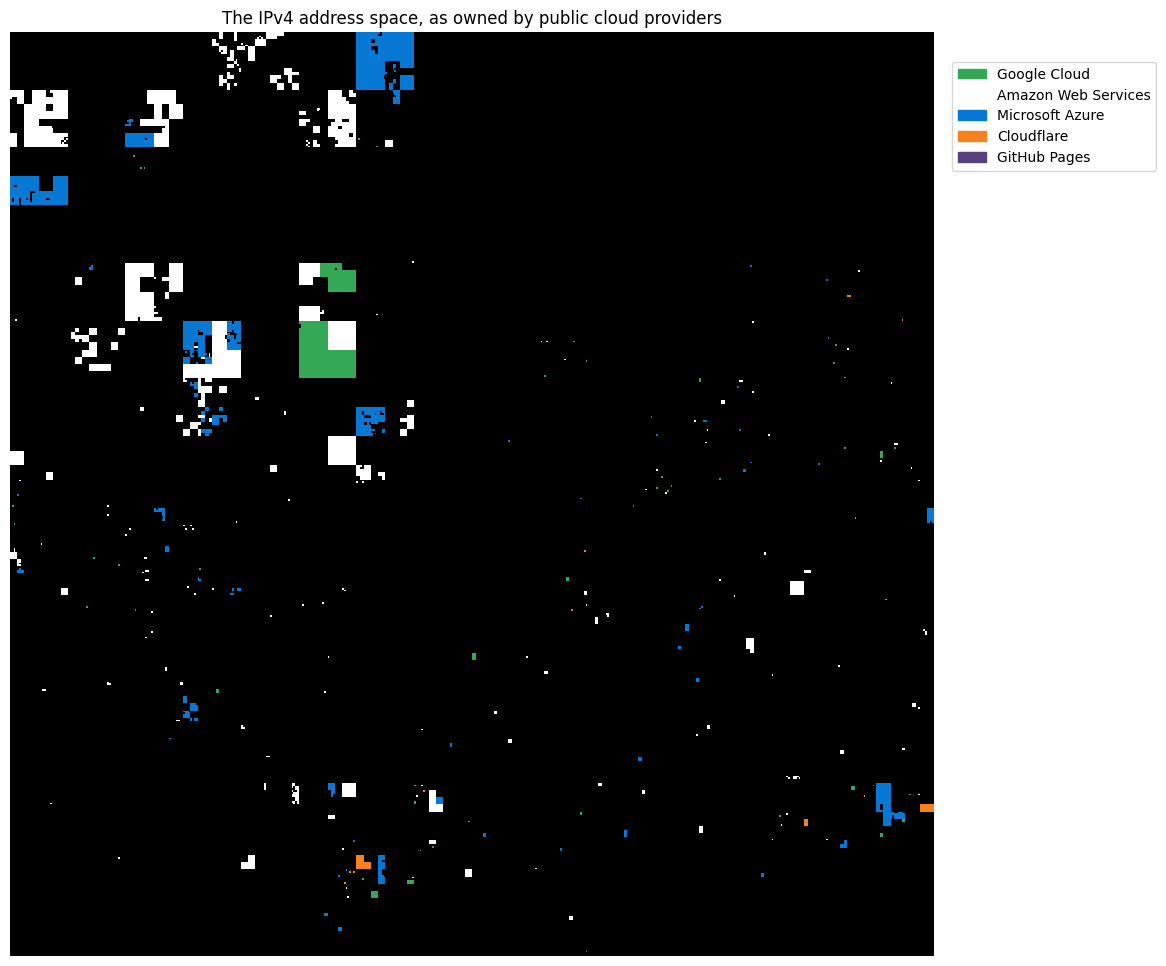

In [2]:
ipAddresses = json.load(open("/kaggle/input/cmsc320-list-of-ipv4-address-ranges/allIPv4Addresses.json"))
    
colormap = {
    "Google Cloud": np.array([52, 168, 84]),
    "Amazon Web Services": np.array([255, 255, 255]),
    "Microsoft Azure": np.array([7, 121, 213]),
    "Cloudflare": np.array([246, 130, 30]),
    "GitHub Pages": np.array([88, 64, 125])
}

def bit_count_is_one(n):
    while n:
        if n & 1:
            n = n >> 1
            return n == 0
        else:
            n = n >> 1

def plot_hilbert_map(ip_list, resolution=255):
    map = np.zeros(shape=(resolution, resolution, 3), dtype=np.uint8)
    if resolution > 65536:
        raise ValueError("The maximum supported resolution is 65536x65536 pixels.")
    if not bit_count_is_one(resolution):
        raise ValueError("The resolution must be a power of 2.")
    ip_range_step = max((2**32 // (resolution * resolution)), 1)
    for i in trange(len(ip_list)):
        ip_nums = np.arange(int(ip_list[i][0][0]), int(ip_list[i][0][1]), ip_range_step, dtype=np.uint32)
        ip_coords = hilbert.decode(ip_nums, 2, 16)
        ip_coords = (ip_coords * resolution) // 65536

        map[ip_coords[..., 1], ip_coords[..., 0]] = colormap[ip_list[i][1]]

        # This distinguishes between different subnets owned by the same provider, good if looking at data closely
        # disabled to avoid info overload
        #map[ip_coords[..., 1], ip_coords[..., 0]] = np.clip(np.clip(colormap[ip_list[i][1]] + np.random.randint(-10, 0, size=3), 0, 255) + np.random.randint(0, 10, size=3), 0, 255)
    plt.figure(figsize=(12, 12))
    plt.title("The IPv4 address space, as owned by public cloud providers")
    plt.axis('off')
    plt.imshow(map, interpolation='nearest')
    patches = [mpatches.Patch(color=[v/255 for v in color], label=name) for name, color in colormap.items()]
    plt.legend(handles=patches, loc=[1.02, 0.85])

    plt.imsave("map.png", map)

random.shuffle(ipAddresses)
#plot_hilbert_map([[[127*(2**24), 128*(2**24)], "Amazon Web Services"]], resolution=256)
plot_hilbert_map(ipAddresses, resolution=512)
plt.show()

### __1.4. Downloading and Preprocessing Data__

The initial data from the CrUX was uploaded to Kaggle as a private dataset, from which we used Kaggle Notebooks to perform preprocessing and analysis. This was spread between a set of multiple Kaggle notebooks to take advantage of a feature Kaggle offers known as pipelines. Effectively, Kaggle allows us to have one version of a notebook depend on other notebooks (including the last successful version of itself) or on private/public datasets (allowing for up to 100GB of private datasets per user and unlimited public datasets). This allows us to "cache" outputs of each stage of the preprocessing pipeline so that previous stages do not need to be run again. The best part is that this "cache" storage is free, because Kaggle does not limit storage output from notebooks, only storage uploaded through datasets.

Notebooks used for preprocessing data, as well as other scripts called by these notebooks, are avaliable in this GitHub repository: https://github.com/web-frameworks-research/web_framework_scraper.

Kaggle has a feature known as "Save and Run All" that allows running a notebook in the background. This was used to allow repeatedly running a background task, for about nine hours at a time, to gather data on a virtual machine. We used the "pipeline" ability of one particular notebook to link this notebook's output back to its input, allowing the notebook to persist data between runs and revert back to the last successful state if an error occurs. Gathering the dataset took a total of 196 virtual machine hours, equivalent to 784 CPU-core hours. The process of doing so was mostly I/O-bound. We were able to do all processing within Kaggle's free tier, as we did not need any GPUs.

# __Part 2: Explanation of the Dataset__

There are a plethora of features in this dataset. 

__Performance metric statistics__:
For each of the "metrics" columns below, these four statistics are avaliable in the dataset.
- fast_`<metric>`: the percentage of websites that have a "fast" value for the metric
- slow_`<metric>`: the percentage of websites that have a "slow" value for the metric
- avg_`<metric>`: the percentage of websites that have a "average" value for the metric
- p75_`<metric>`: the 75th percentile value of the metric

__Metrics__:
- fp (First Paint): measures the time taken to render the first visual element on the screen
- fcp (First Contentful Paint): measures the time taken to render the first contentful element 
- dcl (DOMContentLoaded): measures the time at which the HTML document has been completelty loaded and parsed
- ol (onload): measures the time it takes for the entire page to fully load 
- fid (First Input Delay): measures the time from when a user first interacts with the website
- ttfb (Time to First Byte): measures the time for a user's browser to receive the first byte of page content from the server
- cls (Cumulative Layour Shift): measures the sum of all individual layout shift scores for every unexpceted layout shift that occurs
- lcp (Largest Contentful Paint): measures the render time of largest image/text bloc
- inp (Interaction to Next Paint): measures how quickly a website responds to user interactions

For more information on these metrics, check out: https://web.dev/explore/metrics.

__Popularity Metrics__: 

- rank: a rank of how popular the website is, rounded up to the closest bucket:
    - top 1,000
    - top 5,000
    - top 10,000
    - top 50,000
    - top 100,000
    - top 500,000
    - top 1,000,000
    - top 5,000,000
    - top 10,000,000
    - top 50,000,000

In our dataset, websites in the "top 50,000,000" bucket were omitted, as we only collected data for the top 10 million websites. This analysis uses the top 1 million websites only, as this is the limit for how much fits in memory on the device where we are doing this analysis. As a future step, we may get a device with more memory or explore alternative options so that we can actually run the full analysis.

- deviceDensity: the percent of total requests to the domain that come from this device type


__Web Frameworks__:

- detectedCloudPlatforms: these are the cloud platforms that are detected on the website

- whatrunsData: this is a JSON object that details specific technologies used by the website. These include frameworks, libraries, and other tools that the website uses to run.


__Other__: 

- Protocol: This is the pretty much the same for all websites (HTTP or HTTPS)

- Domain: the domain name of the website

- siteIsOnline: boolean value of whether the site was still online when data was collected (As we used the CrUX dataset from January 2024, a `false` value in this column means that the site was online in January 2024, but consistently offline in Feburary 2024 when the data was collected, across multiple attempts to contact the website)

- numIPAddressesDetected: the number of IP addresses detected for the website

# ___Part :. Exploratory Data Analysis__

## __3.1: Basic Data Exploration__

Below are all the columns of the dataset:

In [3]:
df = pd.read_parquet("/kaggle/input/assignment-2-statistical-analysis/website_data.parquet")
df.head()

,date,device,fast_fp,avg_fp,slow_fp,p75_fp,fast_fcp,avg_fcp,slow_fcp,p75_fcp,...,p75_inp_origin,protocol,domain,siteIsOnline,numIpAddressesDetected,detectedCloudPlatforms,whatrunsDateUnixMillis,whatrunsData,rank,deviceDensity
0,2024-01-01,tablet,0.0063,0.0071,0.0021,2200.0,0.0095,0.0030,0.0038,2700.0,...,150.0,https:,www.carltonlgrayfuneral.com,True,2.0,"[""Amazon Web Services (us-east-1)""]",NaT,{},1000000,0.0163
1,2024-01-01,desktop,0.3132,0.1539,0.0920,2000.0,0.4066,0.0612,0.0931,2000.0,...,75.0,https:,sede.aytoalmeria.es,True,1.0,[],2021-07-04 18:17:50.033,"{""CMS"":[{""name"":""Liferay"",""category"":1,""icon"":...",1000000,0.5609
2,2024-01-01,desktop,0.7398,0.1557,0.0180,800.0,0.8613,0.0351,0.0176,800.0,...,50.0,https:,secure.rentecdirect.com,True,2.0,"[""Cloudflare""]",2019-08-22 02:21:32.301,"{""Javascript Frameworks"":[{""name"":""jQuery"",""ca...",50000,0.9140
3,2024-01-01,desktop,0.0883,0.0561,0.0165,1900.0,0.1194,0.0276,0.0164,1900.0,...,100.0,https:,seventeen-web.jp,True,4.0,"[""Amazon Web Services (GLOBAL)""]",2023-09-28 01:57:04.916,"{""Widgets"":[{""name"":""Twitter"",""category"":5,""ic...",1000000,0.1634
4,2024-01-01,desktop,0.0973,0.3047,0.0446,2000.0,0.3127,0.1017,0.0473,2000.0,...,100.0,https:,servicematica.com,True,1.0,[],2019-05-29 07:47:05.473,"{""Analytics"":[{""name"":""Google Analytics"",""cate...",1000000,0.4617


For this analysis, we have loaded the first 1 million domains (10%) present in the dataset. Our dataset contains 10 million rows, but we were not able to use the entire dataset as it does not fit into RAM onto any of the devices we have access to.

In the future, we may seek access to a machine with more computational resources in order to perform the full analysis of all 10 million rows. Alternatively, we may use a framework like `dask`, which has the capability to process data that is larger-than-memory, in order to process the dataset. This will likely require a machine with a faster hard drive than what is offered by Kaggle in order for the analysis to proceed at any significant speed.

In [4]:
# Google considers an "origin" to be domain + protocol, hence us using df[["protocol", "domain"]] instead of just df["domain"] when calculating the number of unique rows in the dataset
df[["protocol", "domain"]].drop_duplicates().shape[0]

1000000

## __3.2: Analysis #1__

In our first analysis, we aim to find the relationship between the average FCP time and device type. 

In the plot created, it's apparent that perfromance differs by device type. It suggests that websites might not be as optimized for phones and tablets as they are for desktops.  

We use a Kruskal-Wallis test because it doesn't assume a normal distribution of the data, it's less sensistive to outliers, and it allows for comparison across multiple groups (in this case, device types). 

<Figure size 1000x600 with 0 Axes>

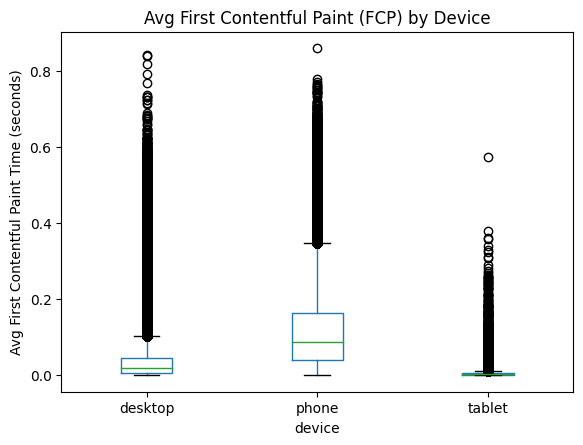

In [5]:
df['avg_fcp'] = pd.to_numeric(df['avg_fcp'], errors='coerce')
analysis1_df = df.dropna(subset=['avg_fcp'])

plt.figure(figsize=(10, 6))
analysis1_df.boxplot(column='avg_fcp', by='device', grid=False)
plt.title('Avg First Contentful Paint (FCP) by Device')
plt.suptitle('')  
plt.ylabel('Avg First Contentful Paint Time (seconds)')
plt.show()

In [6]:
analysis1_df.groupby('device', observed=False)['avg_fcp'].describe()

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,863765.0,0.037779,0.053274,0.0,0.0071,0.0185,0.0455,0.8403
phone,962873.0,0.113857,0.096832,0.0,0.0401,0.0867,0.1630,0.8590
tablet,432343.0,0.004976,0.007022,0.0,0.0018,0.0032,0.0058,0.5740


__Pairwise test__

In this part, we will conduct a Mann-Whitney U test pairwise between all three groups of devices. This allows us to find differences between each group, while the Kruskal-Wallis gave 
a global test. We want to check if there's a significant difference in the average performances of websites across devices. A low or zero p-value will reject the null hypothesis (which in this 
case would be: there is no difference in average fcp of websites across devices). Conducting this pairwise test allows us to make better statistical inferences.

In [7]:
h_stat, p_value = kruskal(
    analysis1_df[analysis1_df['device'] == 'desktop']['avg_fcp'],
    analysis1_df[analysis1_df['device'] == 'tablet']['avg_fcp'],
    analysis1_df[analysis1_df['device'] == 'phone']['avg_fcp']
)

print(f"H-statistic: {h_stat}, P-value: {p_value}")

H-statistic: 1105466.7124264364, P-value: 0.0


In [8]:
comparisons = [('desktop', 'phone'), ('desktop', 'tablet'), ('phone', 'tablet')]

p_values = []
for group1, group2 in comparisons:
    stat, p = mannwhitneyu(
        analysis1_df[analysis1_df['device'] == group1]['avg_fcp'],
        analysis1_df[analysis1_df['device'] == group2]['avg_fcp'],
        alternative='two-sided'
    )
    p_values.append(p)
    print(f"Mann-Whitney test between {group1} and {group2} gives p-value of {p}")

Mann-Whitney test between desktop and phone gives p-value of 0.0
Mann-Whitney test between desktop and tablet gives p-value of 0.0
Mann-Whitney test between phone and tablet gives p-value of 0.0


In [9]:
del analysis1_df

### __Conclusion #1__

$H_0$: There is no difference in average fcp times across devices

$H_\alpha$: There is a stastically significant difference in average fcp times across devices

The Kruskal-Wallis test gives a p-value of 0, which indicates we can reject the null hypothesis.

## __3.3: Analysis #2__

In our second analysis we are attempting to analyze the breakdown of websites being accessed on different devices. This dataset categorizes devices into three types: desktops, phones, and tablets. We want to find out which devices may draw the most usage and look for factors that may influence the final breakdown. We also want to find out if a some websites are more popular amongst certain devices. Understanding this information may be useful for understanding what devices are most useful for each person depending on what they tend to browse. In a day in age where devices are so expensive, understanding what websites are browsed upon on what devices can be a factor in deciding how to develop websites for different devices.

In [10]:
pd.crosstab(df['device'], df['domain'])

domain,0-1.ir,0-105.com,0-infoweb-newsbank-com.www.saclibrarycatalog.org,0.blueperfectballon.com,0.discoverapp.com,0.fiveminutes.biz,0.freebasics.com,0.lan05.biz,0.leftblastermode.com,0.lords.lat,...,zzz.myworkplace.aviva.co.uk,zzzcode.ai,zzzquilnatura.it,zzzscore.com,zzztop.x.yupoo.com,zzzttt01.com,zzztube.com,zzztube.tv,zzzz.com,zzzzap.nl
device,,,,,,,,,,,,,,,,,,,,,
desktop,1,1,1,0,0,1,0,0,0,1,...,1,1,1,1,1,1,1,1,0,1
phone,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tablet,0,1,0,1,0,1,0,0,1,1,...,1,0,1,0,0,0,1,1,0,0


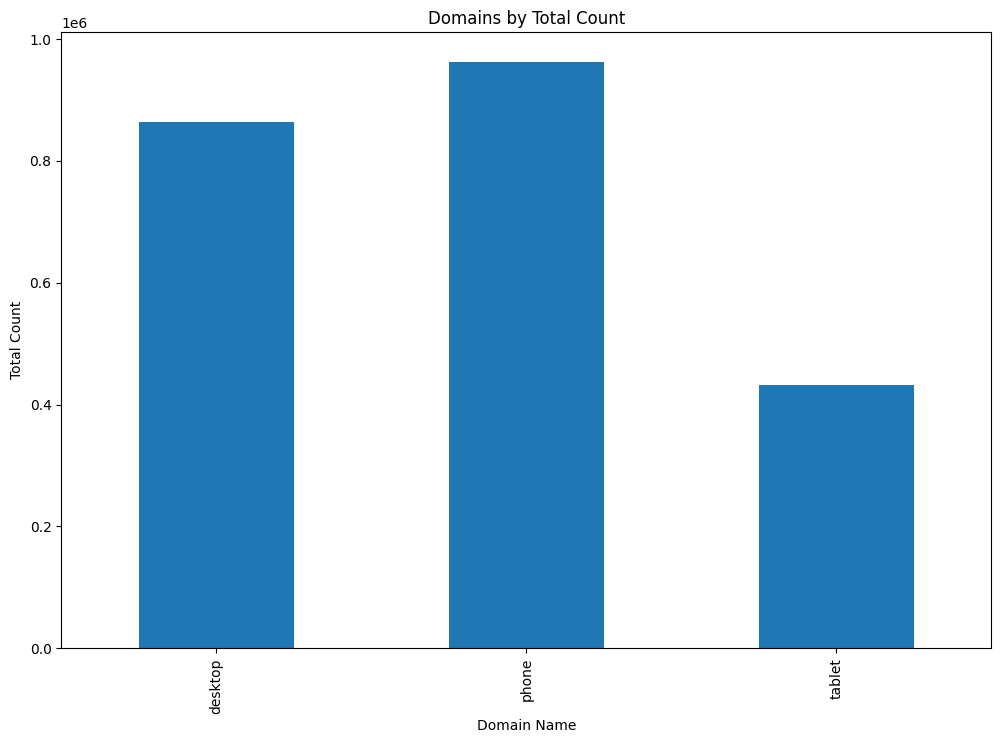

In [11]:
data = pd.crosstab(df['device'], df['domain'])
data['Total'] = data.sum(axis=1)

plt.figure(figsize=(12, 8))
data['Total'].plot(kind='bar')
plt.xlabel('Domain Name')
plt.ylabel('Total Count')
plt.title('Domains by Total Count')
plt.show()

In [12]:
observed = pd.crosstab(df['device'], df['domain'])
_, p_value, _, _ = cont.chi2_contingency(observed.to_numpy())
print(p_value)

1.0


### __Conclusion #2__
Null Hypothesis: There is no association between the type of device and the domain used.

Alternative Hypothesis: There is an association between the type of device and the domain used.

The p value is greater than the level of significance of 0.05 so we support the null hypothesis. Thus, there is no correlation between the device used and the domain used (the device used doesn't affect the popularity of a given website).

After analysis we found that there isn't an association between the the devices and the domain used. Thus, websites that a user likes to browse aren't a factor in the device they may use or prefer. Typically, websites can be accessed on all types of devices these days but we wanted to see if their functionality may be better on some which may lead to a preference toward certain devices. However, in the end we found that device type does not play a part in websites that users access.

## __3.4: Analysis #3 -= Doe using a cloud provider affect webstie performance?__

In this section, we aim to determine the correlation between the list of cloud providers and the first contentful paint (FCP) of a website. FCP refers to the amount of time elapsed between the user navigating to a website and the website beginning to show useful data on the screen.

We can use a t-test to compare the FCP for websites that don't use a cloud provider to websites that do. The hypotheses are below:

$H_0$: for a particular cloud provider, the average FCP of sites using that cloud provider is equal to the average FCP of sites not using that cloud provider.

$H_\alpha$: for a particular cloud provider, the average FCP of sites using that cloud provider is not equal to the average FCP of sites not using that cloud provider.

In [13]:
pd.DataFrame(df["detectedCloudPlatforms"].unique())

,0
0,"[""Amazon Web Services (us-east-1)""]"
1,[]
2,"[""Cloudflare""]"
3,"[""Amazon Web Services (GLOBAL)""]"
4,"[""Amazon Web Services (us-west-1)""]"
...,...
163,"[""Amazon Web Services (us-west-1)"",""Amazon Web..."
164,"[""Amazon Web Services (sa-east-1)"",""Amazon Web..."
165,"[""Amazon Web Services (us-east-2)"",""Amazon Web..."
166,"[""Amazon Web Services (eu-central-1)"",""Amazon ..."


In [14]:
name_replacements = {"Amazon Web Services": "AWS", "Microsoft Azure": "Azure"}
def shorten_name(name):
    name = re.sub(r'(.+?)( \(.+\)|)$', r'\1', name)
    if name in name_replacements: return name_replacements[name]
    else: return name
    
def remove_region_info(string):
    if string is None: return None
    return frozenset({sys.intern(shorten_name(x)) for x in json.loads(string)})
df["detectedCloudPlatformsNoRegion"] = df["detectedCloudPlatforms"].apply(remove_region_info)

df["detectedCloudPlatformsNoRegion"].unique()


array([frozenset({'AWS'}), frozenset(), frozenset({'Cloudflare'}),
       frozenset({'Google Cloud'}), frozenset({'Azure'}), None,
       frozenset({'GitHub Pages'}), frozenset({'Cloudflare', 'AWS'}),
       frozenset({'Azure', 'Google Cloud'}),
       frozenset({'Google Cloud', 'AWS'}),
       frozenset({'Cloudflare', 'Google Cloud'})], dtype=object)

In [15]:
df.groupby("domain", observed=True)["date"].count()

domain
0-1.ir                                              2
0-105.com                                           3
0-infoweb-newsbank-com.www.saclibrarycatalog.org    1
0.blueperfectballon.com                             2
0.discoverapp.com                                   1
                                                   ..
zzzttt01.com                                        2
zzztube.com                                         3
zzztube.tv                                          3
zzzz.com                                            1
zzzzap.nl                                           2
Name: date, Length: 997183, dtype: int64

<Axes: ylabel='count'>

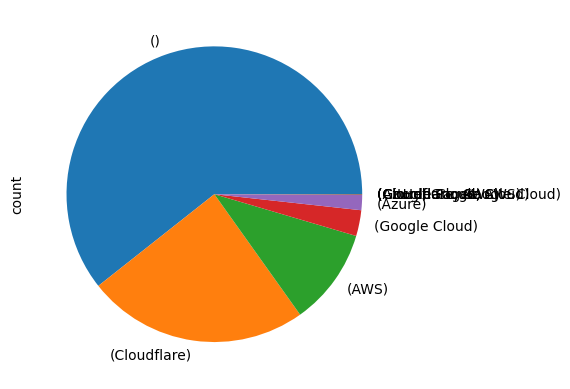

In [16]:
df["detectedCloudPlatformsNoRegion"].value_counts().plot.pie()

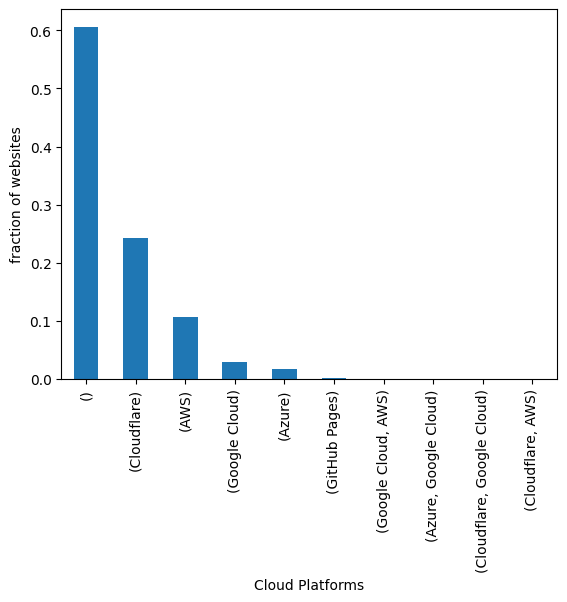

In [17]:
percentages = (df["detectedCloudPlatformsNoRegion"].value_counts()/df["detectedCloudPlatformsNoRegion"].count())

ax = percentages.plot.bar(xlabel = "Cloud Platforms", ylabel = "fraction of websites")

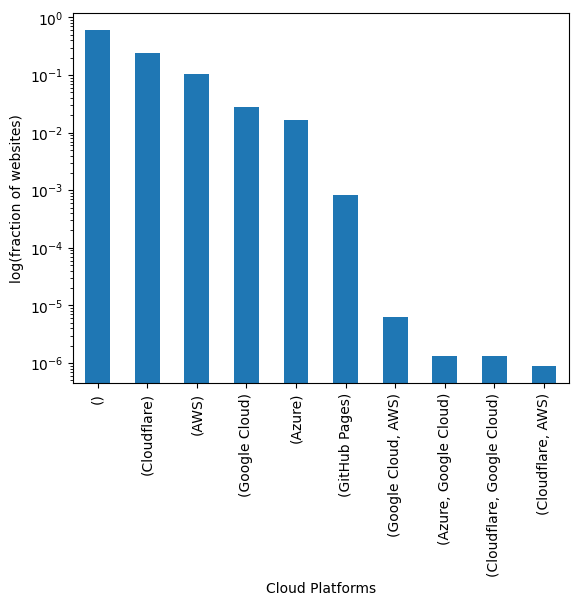

In [18]:
percentages = (df["detectedCloudPlatformsNoRegion"].value_counts()/df["detectedCloudPlatformsNoRegion"].count())

ax = percentages.plot.bar(xlabel = "Cloud Platforms", ylabel = "log(fraction of websites)", log=True)

In [19]:
all_cloud_platforms_series = pd.Series(list(reduce(lambda x,y:x if y is None else y if x is None else x|y, df["detectedCloudPlatformsNoRegion"].unique())))
all_cloud_platforms = pd.DataFrame()
all_cloud_platforms["Platform"] = all_cloud_platforms_series
del all_cloud_platforms_series

mean_fcp_vals = []
stdev_fcp_vals = []
baseline_mean_fcp = []
degrees_of_freedom = []
t_statistic_vals = []
p_values = []
conclusion_str = []

for platform in tqdm(all_cloud_platforms["Platform"]):
    test_index = df["detectedCloudPlatformsNoRegion"].apply(lambda s: s if s is not None else frozenset()).apply(lambda s:platform in s)
    test_df = df[test_index]
    opp_df = df[~test_index]
    current_mean = test_df["avg_fcp"].mean()
    mean_fcp_vals.append(current_mean)
    stdev_fcp_vals.append(test_df["avg_fcp"].std())
    baseline_mean = opp_df["avg_fcp"].mean()
    baseline_mean_fcp.append(baseline_mean)
    
    result = ttest_ind(test_df["avg_fcp"].dropna(), opp_df["avg_fcp"].dropna())
    
    degrees_of_freedom.append(result.df)
    t_statistic_vals.append(result.statistic)
    p_values.append(result.pvalue)
    
    if result.pvalue < 0.05:
        conclusion_str.append(f"Reject H0. Websites using {platform} are statistically significantly {'slower' if current_mean > baseline_mean else 'faster'} to load than other websites.")
    else:
        conclusion_str.append(f"Fail to reject H0, {platform} produces no statistically significant difference.")

all_cloud_platforms["Mean FCP with this provider (s)"] = mean_fcp_vals
all_cloud_platforms["Standard Deviation FCP (s)"] = stdev_fcp_vals
all_cloud_platforms["Mean FCP without this provider (s)"] = baseline_mean_fcp
all_cloud_platforms["t-statistic"] = t_statistic_vals
all_cloud_platforms["p-values"] = p_values
all_cloud_platforms["Conclusion"] = conclusion_str

del mean_fcp_vals
del stdev_fcp_vals
del baseline_mean_fcp
del t_statistic_vals
del p_values
del conclusion_str

all_cloud_platforms

  0%|          | 0/5 [00:00<?, ?it/s]

,Platform,Mean FCP with this provider (s),Standard Deviation FCP (s),Mean FCP without this provider (s),t-statistic,p-values,Conclusion
0,Azure,0.062688,0.076001,0.063949,-2.855931,4.291118e-03,Reject H0. Websites using Azure are statistica...
1,GitHub Pages,0.048853,0.073326,0.063941,-7.775645,7.509559e-15,Reject H0. Websites using GitHub Pages are sta...
2,Cloudflare,0.072740,0.093057,0.061140,88.687003,0.000000e+00,Reject H0. Websites using Cloudflare are stati...
3,AWS,0.069255,0.085034,0.063302,32.621479,2.306417e-233,Reject H0. Websites using AWS are statisticall...
4,Google Cloud,0.076173,0.096928,0.063575,37.151782,5.067061e-302,Reject H0. Websites using Google Cloud are sta...


In [20]:
max_colwidth_val = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', 0)
all_cloud_platforms[["Platform", "Conclusion"]]

,Platform,Conclusion
0,Azure,Reject H0. Websites using Azure are statistically significantly faster to load than other websites.
1,GitHub Pages,Reject H0. Websites using GitHub Pages are statistically significantly faster to load than other websites.
2,Cloudflare,Reject H0. Websites using Cloudflare are statistically significantly slower to load than other websites.
3,AWS,Reject H0. Websites using AWS are statistically significantly slower to load than other websites.
4,Google Cloud,Reject H0. Websites using Google Cloud are statistically significantly slower to load than other websites.


In [21]:
pd.set_option('display.max_colwidth', max_colwidth_val)
del max_colwidth_val

### __Conclusion #3__
The results were surprisingly varied between cloud providers, but all results were highly statistically significant, with p-values that amounted to rounding errors. While the magnitude of the difference was relatively small, we were able to find a meaningful statistically significant difference
5 t-tests were performed between the list of websites using a particular cloud provider and the list of websites not using that particular provider.
We ultimately concluded:

- Websites using GitHub Pages are statistically significantly faster to load than other websites. (p=7.509559e-15)
- Websites using Cloudflare are statistically significantly slower to load than other websites. (p-value too low to measure)
- Websites using Google Cloud are statistically significantly slower to load than other websites. (p=5.067061e-302)
- Websites using AWS are statistically significantly slower to load than other websites. (p=2.306417e-233)
- Websites using Azure are statistically significantly faster to load than other websites. (p=4.291118e-03)


That said, it is important to note that the differences we noticed here are not that large, and any of these cloud providers would suffice to host websites on. The most important factor in the performance of a website is code quality.

# __Part 4: Primary Analysis__

In this section, we want to create a regression model to predict the performance of a website based on its web framework. For context, regression takes in input data and predicts a real valued (continuous) feature. For this model, we are using a Random Forest-based regression model. Due to the size of our dataset we believed a random forest model would be best at handling the amount of data as well as providing high accuracy due to it aggregating multiple trees. Also, due to the use of multiple trees, we can better avoid overfitting in cases where certain splits share very similar information and could be prone to noise.

### __4.1: Preprocessing__

To run the Primary Analysis, we first need to process the JSON values present in the `whatrunsData` column of our dataset in order to produce a one-hot-encoded vector of frameworks.

Let's also remove redundancy between the desktop and mobile versions of the website, as we can safely assume that the frameworks the website uses will be the same in both cases.

We will take the average FCP value across all these device types as our dependent variable.

In [22]:
primary_analysis_df = df[df["rank"] <= 100000].dropna(subset=['whatrunsData', 'avg_fcp'])
primary_analysis_df = primary_analysis_df[["domain", "protocol", "whatrunsData", "avg_fcp", "deviceDensity"]]

weighted_avg_fcp = (primary_analysis_df["avg_fcp"] * primary_analysis_df["deviceDensity"]).groupby([primary_analysis_df["domain"], primary_analysis_df["protocol"]], observed=True).sum() / primary_analysis_df.groupby([primary_analysis_df["domain"], primary_analysis_df["protocol"]], observed=True)["deviceDensity"].sum()

result_df = pd.DataFrame(weighted_avg_fcp, columns=["avg_fcp"])

result_df["whatrunsData"] = primary_analysis_df.groupby([primary_analysis_df["domain"], primary_analysis_df["protocol"]], observed=True)["whatrunsData"].first()

result_df.loc[result_df["whatrunsData"].isnull(), "whatrunsData"] = None

result_df.reset_index(inplace=True)

primary_analysis_df = result_df
del result_df

In [23]:
primary_analysis_df

,domain,protocol,avg_fcp,whatrunsData
0,0.freebasics.com,https:,0.196400,{}
1,0.torrentoyunindir.com,https:,0.012953,"{""CMS"":[{""name"":""WordPress"",""category"":1,""icon..."
2,01.emailinboundprocessing.eu,https:,0.101151,"{""Javascript Frameworks"":[{""name"":""jQuery"",""ca..."
3,011810.com,https:,0.005777,"{""Web Server"":[{""name"":""Nginx"",""category"":22,""..."
4,018support.metro.tokyo.lg.jp,https:,0.045722,{}
...,...,...,...,...
99054,zzzcode.ai,https:,0.030939,"{""Widgets"":[{""name"":""ShareThis"",""category"":5,""..."
99055,zzzscore.com,https:,0.028105,{}
99056,zzztube.com,https:,0.039315,"{""Analytics"":[{""name"":""Google Analytics"",""cate..."
99057,zzztube.tv,https:,0.063117,"{""Programming Language"":[{""name"":""PHP"",""catego..."


Let's look at the internal structure of a WhatRuns JSON object:

In [24]:
json.loads(primary_analysis_df[
    (primary_analysis_df["domain"] == 'pandas.pydata.org') &
    (primary_analysis_df["protocol"] == 'https:')
].iloc[0]["whatrunsData"])

{'Documentation': [{'name': 'Sphinx',
   'category': 4,
   'icon': 'Sphinx.png',
   'index': '699',
   'sourceUrl': 'https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html',
   'detectedTime': 1676902124518,
   'latestDetectedTime': 1676902124518,
   'website': 'https://www.whatruns.com/click/?target=sphinx.pocoo.org',
   'siteListUrl': 'https://www.whatruns.com/technology/sphinx'}],
 'Analytics': [{'name': 'Google Analytics',
   'category': 10,
   'icon': 'GA.png',
   'index': '274',
   'version': 'UA',
   'sourceUrl': 'https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html',
   'detectedTime': 1676902124518,
   'latestDetectedTime': 1676902124518,
   'website': 'https://www.whatruns.com/click/?target=google.com%2Fanalytics',
   'siteListUrl': 'https://www.whatruns.com/technology/google-analytics'}],
 'Javascript Frameworks': [{'name': 'jQuery',
   'category': 12,
   'icon': 'jQuery.png',
   'index': '894',
   'version': '3.6.0',
   'sourceUrl': 'https://pandas.pydat

We can see that the outer object is a dictionary, containing keys that refer to categories. For each of these keys, the values are dictionaries that refer to individual frameworks and metadata associated with them. This includes the name, links to more info about the framework, as well as an id uniquely identifying the framework.

First, we need to find a list of all categories containing web frameworks. In this script, to save RAM, we will be using the indexes of categories to represent the category in question, as opposed to the actual category name. We will maintain a mapping from names to indexes and from indexes to names.

In [25]:
tqdm.pandas() # adds progress_apply to dataframes

# note: we use json.loads multiple times in this analysis.
# This is for good reason - python dictionaries are less memory-efficient than raw JSON data,
# so we want to minimize the number of them created at any one time
def getWhatRunsCategories(whatrunsObj):
    return frozenset(json.loads(whatrunsObj).keys())
whatrunsDataCategories = primary_analysis_df["whatrunsData"].progress_apply(getWhatRunsCategories)
allWhatrunsDataCategories = set()
for whatrunsCategories in tqdm(whatrunsDataCategories):
    allWhatrunsDataCategories.update(whatrunsCategories)
allWhatrunsDataCategories = sorted(allWhatrunsDataCategories)
allWhatrunsDataCategoriesReverse = {x:i for i,x in enumerate(allWhatrunsDataCategories)}
del whatrunsDataCategories

# the list of all categories
allWhatrunsDataCategories

  0%|          | 0/99059 [00:00<?, ?it/s]

  0%|          | 0/99059 [00:00<?, ?it/s]

['Advertising',
 'Affiliate Marketing',
 'Affiliate Networks',
 'Analytics',
 'Blogs',
 'Build CI Systems',
 'CDN',
 'CMS',
 'Cache',
 'Captcha',
 'Comments and Reviews',
 'Communication',
 'Database',
 'Databases',
 'Dev Tools',
 'Document Management Systems',
 'Documentation',
 'Editors',
 'Feed Readers',
 'Finance and Accounting',
 'Font Script',
 'Gallery',
 'Hosting Panel',
 'Issue Tracker',
 'Javascript Frameworks',
 'Javascript Graphics',
 'LMS',
 'Landing Page Builders',
 'Maps',
 'Media Server',
 'Message Board',
 'Miscellaneous',
 'Miscellaneous 1',
 'Mobile Frameworks',
 'Operating System',
 'Payment Processors',
 'Paywalls',
 'Programming Language',
 'Rich Text Editors',
 'Sales and Marketing',
 'Search Engine',
 'Tag Managers',
 'Video',
 'Web Framework',
 'Web Mail',
 'Web Server',
 'Web Server Extensions',
 'Widgets',
 'Wiki']

Next, let's get a full list of WhatRuns frameworks and determine which frameworks each site uses.

In [26]:
whatrunsFrameworkNamesFreq = dict()
whatrunsFrameworkToCategoryId = dict()

def getWhatRunsFrameworkNamesAndIndexes(whatrunsObj):
    global whatrunsFrameworkNamesFreq
    global whatrunsFrameworkToCategoryId
    whatrunsObj = json.loads(whatrunsObj)
    list_framework_names = []
    for category_name in whatrunsObj:
        for framework in whatrunsObj[category_name]:
            framework_name = framework['name']
            whatrunsFrameworkToCategoryId[framework_name] = allWhatrunsDataCategoriesReverse[category_name]
            if framework_name in whatrunsFrameworkNamesFreq:
                whatrunsFrameworkNamesFreq[framework_name] += 1
            else:
                whatrunsFrameworkNamesFreq[framework_name] = 1
            list_framework_names.append(framework_name)
    return frozenset(list_framework_names)

whatrunsDataFrameworkNames = primary_analysis_df["whatrunsData"].progress_apply(getWhatRunsFrameworkNamesAndIndexes)

  0%|          | 0/99059 [00:00<?, ?it/s]

It turns out that there are 8,035 web frameworks that WhatRuns is capable of detecting present in the top million websites on the internet.

In [27]:
len(whatrunsFrameworkNamesFreq)

8035

This is too many (for our computer's RAM). Let's slim this list down to the top 250 frameworks:

In [28]:
whatrunsFrameworkNamesFreq = {k:v for k,v in sorted(whatrunsFrameworkNamesFreq.items(), key=lambda item:item[1], reverse=True)[:250]}

Here's an excerpt:

In [29]:
{k:v for k,v in list(whatrunsFrameworkNamesFreq.items())[:50]}

{'jQuery': 29536,
 'Google Analytics': 19644,
 'Google Tag Manager': 16788,
 'Bootstrap': 12340,
 'PHP': 12006,
 'Nginx': 11277,
 'Google Font API': 10923,
 'CloudFlare': 10204,
 'Apache': 7867,
 'Facebook Pixel': 7849,
 'Facebook': 7797,
 'Font Awesome': 6748,
 'Google AdSense': 6243,
 'DoubleClick (DFP)': 5751,
 'WordPress': 4732,
 'Modernizr': 4345,
 'jQuery UI': 4244,
 'HTML5 Shiv': 4200,
 'Google Ads': 4165,
 'ASP.NET': 4010,
 'CDN JS': 3666,
 'embed JS': 3576,
 'webpack': 3363,
 'Windows Server': 3070,
 'IIS': 3016,
 'Respond JS': 2582,
 'Moment JS': 2508,
 'Twitter Ads': 2187,
 'Twitter Emoji (Twemoji)': 2150,
 'React': 2117,
 'Twitter': 2103,
 'Async': 2065,
 'NewRelic': 1724,
 'reCAPTCHA': 1677,
 'Amazon Cloudfront': 1665,
 'Yoast SEO': 1615,
 'OWL Carousel': 1559,
 'comScore': 1536,
 'Ubuntu': 1455,
 'Yandex.Metrika': 1422,
 'Scorecardresearch': 1417,
 'jsDelivr': 1365,
 'RequireJS': 1350,
 'Hotjar': 1306,
 'Varnish': 1290,
 'LazyLoad': 1245,
 'Criteo': 1222,
 'Google Plus': 

Interestingly enough, the most popular framework on the web, according to this dataset, is jQuery.

For each of these frameworks, let's create a new column in the dataset representing whether the framework is present.

In [30]:
new_cols = dict()
for framework in tqdm(whatrunsFrameworkNamesFreq):
    new_cols[f"{framework}_present"] = whatrunsDataFrameworkNames.apply(lambda s:(framework in s)).astype("bool")

  0%|          | 0/250 [00:00<?, ?it/s]

We created the columns in a dictionary to reduce the fragmentation of the dataframe. We can now add all the columns back to the DataFrame at once:

In [31]:
new_col_names = list(new_cols.keys())
primary_analysis_df = pd.concat(
    [
        primary_analysis_df,
        pd.DataFrame(
            new_cols,
            index=primary_analysis_df.index
        )
    ], axis=1
)
del new_cols

Out of the top 10 million websites on the internet, this is how many use jQuery:

In [32]:
primary_analysis_df["jQuery_present"].sum()

29536

## 4.2: Model Training

In [33]:
#Featuers
X = primary_analysis_df[new_col_names]
#target variable
y = primary_analysis_df['avg_fcp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

with parallel_backend("loky", n_jobs=4):
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

These are the resultant MSE and $r^2$ scores for our model:

In [35]:
mse

0.007117814688800489

In [36]:
r2

0.02281997905241029

As you can see, the correlation found by our model, if any, is quite weak.

# __Part 5: Visualization__

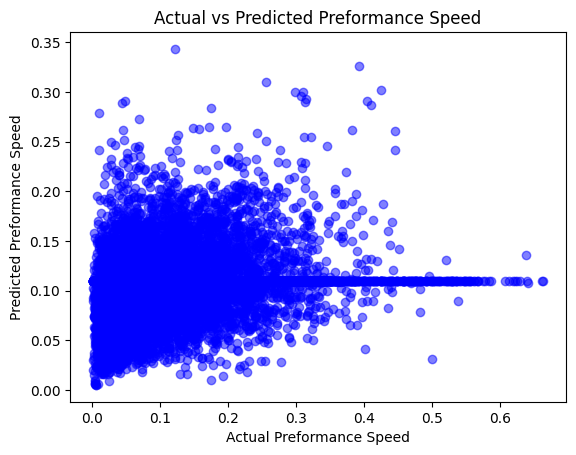

In [37]:
plt.scatter(y_test, y_pred, color = 'blue', alpha = 0.5)
plt.title('Actual vs Predicted Preformance Speed')
plt.xlabel('Actual Preformance Speed')
plt.ylabel('Predicted Preformance Speed')
plt.show()

# __Part 6: Insights and Conclusions__

Overall, we were able to gather many different data points for a large set of websites on the internet and analyze some of their relationships. This includes the frameworks the website uses, the cloud platforms it is hosted on, and many different ways of measuring the performance of the website, including metrics such as first contentful paint, first input delay, and many others.

We also explored certain features of this dataset, and gathered some interesting conclusions. This includes:
- different websites are used across different device types, such as desktop, mobile, and tablet. Some websites are geared more towards some of these categories than others
- websites have different levels of performance on different device types
- all cloud platforms are either statistically significantly faster or slower than other options, but the difference is likely not large enough to matter.

We were also ultimately able to train a large random forest classifier on our dataset, attempting to predict the First Contentful Paint (FCP) - based load time of a website based on the frameworks it uses. Unfortunately, we did not get a strong positive result, as our coefficient of determination $r^2$ was only 0.022. This could be because we only used the top 250 (out of over 8,000) web frameworks to train our web scraper, and many websites potentially don't use these frameworks. One likely potential reason is that, in addition to using web frameworks, a major driver of performance among websites is how efficiently the code is written, which isn't something we can measure with our analysis. If we ever gain access to a big enough machine, we may eventually try to see if using the entire set of frameworks as the training dataset for the Random Forest model provides a significant gain in its $r^2$ score.

Overall, we certainly met our original goal of taking a "census" of the most popular websites avaliable on the internet. This was a great learning experience in terms of working with large datasets using different kinds of statistical tests. The expansive nature of the datset also made it super fun to investigate, as this dataset is a gold mine of potential insights into how the internet works and what makes websites performant and popular. These could ultimately be useful in informing future web developement or analytics projects by giving people a better understanding of what makes the web tick.

Some challenges we encountered include running out of RAM to analyze our dataset with and implementing complex "grouping" operations using Pandas. In general, our issues were associated with dealing with the difficulties associated with a dataset containing over 20 million rows and 50 columns. We ultimately found dealing with these to be a valuable learning experience.

Potential future directions for this project include:
- getting access to a large enough machine to run this analysis for all 10,000,000 data points, and run the random forest analysis with all >8,000 frameworks
- getting access to enough storage to gather all 50 million points represented in the CrUX dataset
- comparing the list of domain names with filtering lists for spam, malware, adult content, etc., to see how common these websites are among the most popular websites of the internet (a preliminary analysis suggests they are, in fact, very common, but more research is necessary)
- determining whether certain types of frameworks are more common among sites containing spam, malware, or adult content
- using different data sources (such as device type, protocol, cloud provider, etc.) and different kinds of models to see if we can, in fact, key predict performance metrics of a website with a higher level of accuracy
- gathering historical or future data and comparing it to current data to see how these metrics change over time.

Acknowledgements
- Dr. Fardina Alam, for supporting us through this course and especially with the help and advice associated with using a custom dataset.